✅ Training dataset loaded
Shape: (1140, 12)
Columns: ['State Name', 'Temp', 'pH', 'Conductivity', 'Nitrate', 'Fecal_Coliform', 'Total_Coliform', 'TDS', 'Fluoride', 'WQI', 'WQI_Classification', 'WQI_Class_Encoded']

📊 Descriptive stats for features + target:


,Temp,pH,Conductivity,Nitrate,Fecal_Coliform,Total_Coliform,TDS,Fluoride,WQI
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,25.928560,7.290300,1376.216271,3.184192,102.320873,221.544772,907.694174,6.779629,48.411726
std,3.863749,0.554214,2301.176128,7.241765,197.677477,364.156103,1422.044642,42.715502,70.360546
min,9.500000,4.950000,46.000000,0.030000,2.000000,2.000000,31.500000,0.210000,0.000000
25%,23.500000,7.050000,325.750000,0.653750,6.487500,20.575000,270.000000,0.367000,23.333333
50%,26.500000,7.340000,763.000000,1.727500,23.000000,79.235000,577.750000,0.473500,36.683237
75%,28.500000,7.631250,1486.625000,3.543750,106.850000,277.200000,999.250000,0.730000,59.902510
max,64.000000,9.400000,34170.000000,204.700000,3100.000000,5150.000000,23530.000000,974.000000,1804.175265



🔧 Split: Train=(912, 8), Test=(228, 8)

🔎 Starting model comparison + hyperparameter tuning...

⏳ Tuning Ridge ...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Ridge: best CV RMSE = 66.327

⏳ Tuning SVR ...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ SVR: best CV RMSE = 60.754

⏳ Tuning RandomForest ...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ RandomForest: best CV RMSE = 43.904

⏳ Tuning GradientBoosting ...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ GradientBoosting: best CV RMSE = 41.223

⏳ Tuning XGBRegressor ...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ XGBRegressor: best CV RMSE = 45.842

🏁 CV Results (lower RMSE is better):


,model,cv_rmse,best_params
3,GradientBoosting,41.223325,"{'model__subsample': 1.0, 'model__n_estimators..."
2,RandomForest,43.904389,"{'model__n_estimators': 800, 'model__min_sampl..."
4,XGBRegressor,45.842297,"{'model__subsample': 0.8, 'model__reg_lambda':..."
1,SVR,60.754411,"{'model__gamma': 'scale', 'model__epsilon': 1...."
0,Ridge,66.327021,{'model__alpha': 100.0}



🥇 Best model selected: GradientBoosting

📈 Hold-out Test Metrics (best model):
R²   : 0.262
MAE  : 13.092
RMSE : 24.382
MAPE : 155983183388688512.000%


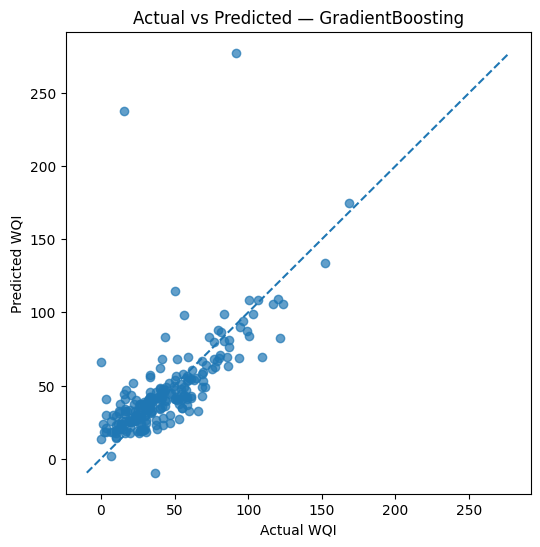

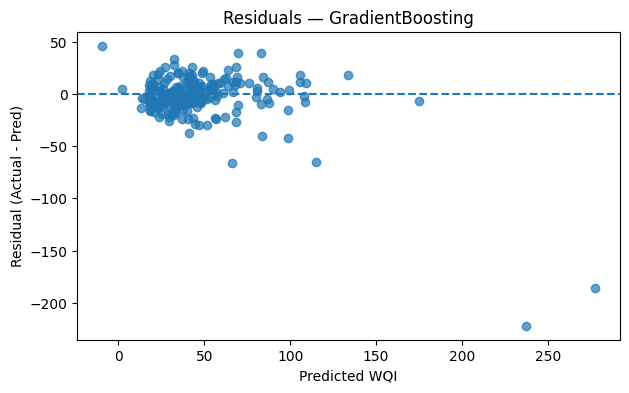

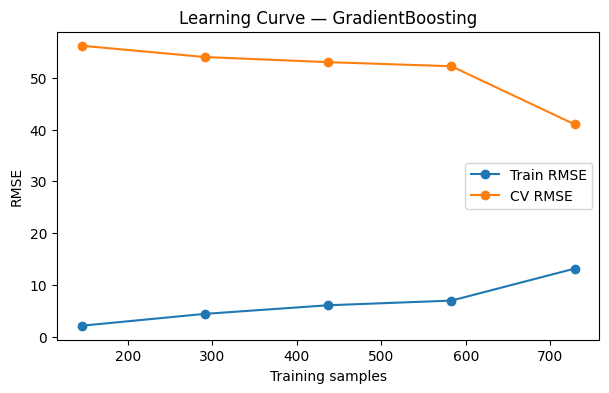

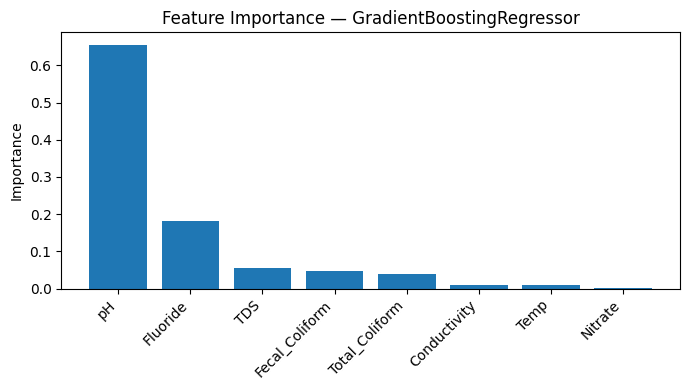

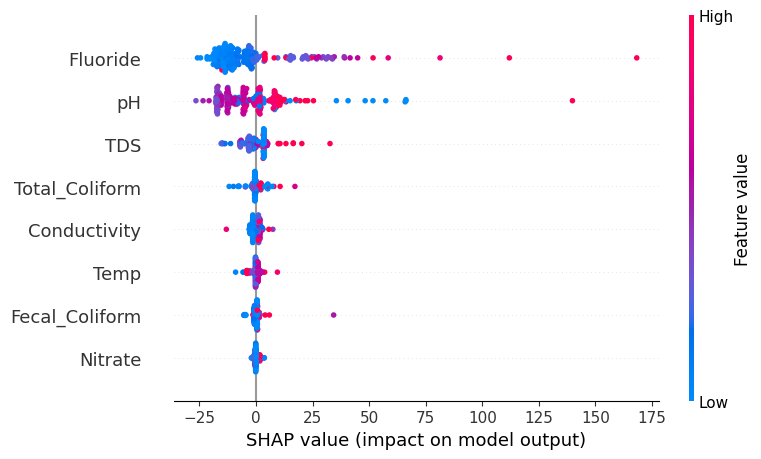


💾 Saved best pipeline to: best_wqi_pipeline__GradientBoosting.pkl

📥 Inference dataset loaded: (1091, 9)
✅ Inference complete. Saved: Predicted_WQI_Scored__GradientBoosting.csv


,Predicted_WQI,WQI_Class
0,39.474802,Good
1,89.062040,Very Poor
2,43.271414,Good
3,84.115321,Very Poor
4,50.719934,Poor
5,50.561945,Poor
6,72.471521,Poor
7,57.120084,Poor
8,74.621599,Poor
9,78.131194,Very Poor


In [1]:
# ================================================================
# 🌊 WQI Regression Project — Model Comparison + Tuning + Deployment
# ================================================================

# 0) Setup & Imports
import warnings, sys, os, json, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

import joblib
np.random.seed(42)

# ---------------------------
# 1) File paths (EDIT if needed)
# ---------------------------
TRAIN_CSV = "NWMP_ML_ready_WQI_filled_v2.csv"          # your training/ready file (has numeric WQI)
NEW_DATA_CSV = "NWMP_DATA_2021_final_trimmed.csv"      # 2021 file for inference

# ---------------------------
# 2) Load training data
# ---------------------------
df = pd.read_csv(TRAIN_CSV)

print("✅ Training dataset loaded")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# ---------------------------
# 3) Feature selection & quick EDA sanity
# Training uses SHORT NAMES; keep these consistent.
# ---------------------------
FEATURES = ['Temp','pH','Conductivity','Nitrate','Fecal_Coliform','Total_Coliform','TDS','Fluoride']
TARGET   = 'WQI'

missing_cols = [c for c in FEATURES+[TARGET] if c not in df.columns]
if missing_cols:
    raise ValueError(f"The training dataset is missing required columns: {missing_cols}")

# Quick description
print("\n📊 Descriptive stats for features + target:")
display(df[FEATURES+[TARGET]].describe())

# Null checks
nulls = df[FEATURES+[TARGET]].isna().sum()
if nulls.sum() > 0:
    print("\n⚠️ Found missing values. Simple forward-fill used only for demo; replace with your imputation if needed.")
    df[FEATURES+[TARGET]] = df[FEATURES+[TARGET]].fillna(method="ffill").fillna(method="bfill")

# ---------------------------
# 4) Train / Test Split
# ---------------------------
X = df[FEATURES].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"\n🔧 Split: Train={X_train.shape}, Test={X_test.shape}")

# ---------------------------
# 5) Build candidate models as Pipelines (Scaler where needed)
#    - Pipelines prevent leakage and keep deployment simple
# ---------------------------
models = {}

# Ridge (linear baseline) — needs scaling
models['Ridge'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=42))
])

# SVR — needs scaling
models['SVR'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

# RandomForest — tree, no scaling required, but we can include a passthrough
models['RandomForest'] = Pipeline([
    ('scaler', 'passthrough'),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# GradientBoosting — tree-based
models['GradientBoosting'] = Pipeline([
    ('scaler', 'passthrough'),
    ('model', GradientBoostingRegressor(random_state=42))
])

# XGBRegressor — tree-based (your preference)
models['XGBRegressor'] = Pipeline([
    ('scaler', 'passthrough'),
    ('model', XGBRegressor(
        random_state=42, n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror', n_jobs=-1
    ))
])

# ---------------------------
# 6) Hyperparameter search spaces (RandomizedSearchCV for speed)
#    NOTE: Param names must be prefixed with 'model__' for pipelines
# ---------------------------
param_spaces = {
    'Ridge': {
        'model__alpha': np.logspace(-3, 2, 30)
    },
    'SVR': {
        'model__C': np.logspace(-2, 3, 20),
        'model__epsilon': np.logspace(-3, 0, 10),
        'model__gamma': ['scale','auto']
    },
    'RandomForest': {
        'model__n_estimators': [200, 400, 600, 800],
        'model__max_depth': [None, 6, 8, 10, 14],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['auto', 'sqrt', 0.7, 0.9]
    },
    'GradientBoosting': {
        'model__n_estimators': [200, 400, 600],
        'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'model__max_depth': [2, 3, 4, 5],
        'model__subsample': [0.8, 1.0],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'XGBRegressor': {
        'model__n_estimators': [300, 500, 800, 1000],
        'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'model__max_depth': [4, 6, 8, 10],
        'model__subsample': [0.7, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__reg_lambda': [0.0, 0.5, 1.0, 2.0],
        'model__reg_alpha': [0.0, 0.1, 0.5]
    }
}

# ---------------------------
# 7) Cross-validated model selection with tuning
# ---------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

best_estimators = {}

print("\n🔎 Starting model comparison + hyperparameter tuning...")
for name, pipe in models.items():
    print(f"\n⏳ Tuning {name} ...")
    params = param_spaces.get(name, {})
    # Smaller n_iter for speed; raise for more exhaustive search
    n_iter = 40 if len(params) > 0 else 1

    if len(params) > 0:
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=params,
            n_iter=n_iter,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            cv=cv,
            random_state=42,
            verbose=1
        )
        search.fit(X_train, y_train)
        best_pipe = search.best_estimator_
        best_score = -search.best_score_  # RMSE (positive)
        print(f"✅ {name}: best CV RMSE = {best_score:.3f}")
        best_params = search.best_params_
    else:
        # No tuning
        pipe.fit(X_train, y_train)
        scores = -cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
        best_pipe = pipe
        best_score = scores.mean()
        best_params = {}

    best_estimators[name] = best_pipe
    results.append({
        'model': name,
        'cv_rmse': best_score,
        'best_params': best_params
    })

results_df = pd.DataFrame(results).sort_values(by='cv_rmse')
print("\n🏁 CV Results (lower RMSE is better):")
display(results_df)

best_model_name = results_df.iloc[0]['model']
best_pipeline = best_estimators[best_model_name]
print(f"\n🥇 Best model selected: {best_model_name}")

# ---------------------------
# 8) Final evaluation on the HOLD-OUT test set
# ---------------------------
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

R2  = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = math.sqrt(mean_squared_error(y_test, y_pred))
MAPE = mean_absolute_percentage_error(y_test, y_pred)

print("\n📈 Hold-out Test Metrics (best model):")
print(f"R²   : {R2:.3f}")
print(f"MAE  : {MAE:.3f}")
print(f"RMSE : {RMSE:.3f}")
print(f"MAPE : {MAPE:.3%}")

# Actual vs Predicted scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlabel("Actual WQI")
plt.ylabel("Predicted WQI")
plt.title(f"Actual vs Predicted — {best_model_name}")
plt.show()

# Residual plot
resid = y_test - y_pred
plt.figure(figsize=(7,4))
plt.scatter(y_pred, resid, alpha=0.7)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted WQI")
plt.ylabel("Residual (Actual - Pred)")
plt.title(f"Residuals — {best_model_name}")
plt.show()

# Learning curve (optional; can be time consuming)
train_sizes, train_scores, valid_scores = learning_curve(
    best_pipeline, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=-1
)
train_rmse = -train_scores.mean(axis=1)
valid_rmse = -valid_scores.mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_rmse, marker='o', label='Train RMSE')
plt.plot(train_sizes, valid_rmse, marker='o', label='CV RMSE')
plt.xlabel('Training samples')
plt.ylabel('RMSE')
plt.title(f'Learning Curve — {best_model_name}')
plt.legend()
plt.show()

# ---------------------------
# 9) Model explainability (Feature importance + SHAP when possible)
# ---------------------------
def plot_tree_importances(pipeline, feature_names):
    # Try to access underlying model (xgboost/sklearn tree)
    mdl = pipeline.named_steps['model']
    importances = None

    # XGB / RF / GBR have feature_importances_
    if hasattr(mdl, 'feature_importances_'):
        importances = mdl.feature_importances_
    # For Ridge/SVR there is no tree-based FI
    if importances is not None:
        idx = np.argsort(importances)[::-1]
        plt.figure(figsize=(7,4))
        plt.bar(range(len(feature_names)), importances[idx])
        plt.xticks(range(len(feature_names)), np.array(feature_names)[idx], rotation=45, ha='right')
        plt.ylabel("Importance")
        plt.title(f"Feature Importance — {type(mdl).__name__}")
        plt.tight_layout()
        plt.show()

try:
    plot_tree_importances(best_pipeline, FEATURES)
except Exception as e:
    print("Feature importance plot skipped:", e)

# SHAP (optional)
try:
    import shap
    mdl = best_pipeline.named_steps['model']
    # If scaler exists, transform a sample for SHAP background properly
    if 'scaler' in best_pipeline.named_steps and best_pipeline.named_steps['scaler'] != 'passthrough':
        X_bg = best_pipeline.named_steps['scaler'].fit_transform(X_train.sample(min(500, len(X_train)), random_state=42))
        X_smp = best_pipeline.named_steps['scaler'].transform(X_test.sample(min(300, len(X_test)), random_state=42))
    else:
        X_bg = X_train.sample(min(500, len(X_train)), random_state=42).values
        X_smp = X_test.sample(min(300, len(X_test)), random_state=42).values

    if isinstance(mdl, XGBRegressor):
        explainer = shap.TreeExplainer(mdl)
        shap_values = explainer.shap_values(X_smp)
        shap.summary_plot(shap_values, features=X_smp, feature_names=FEATURES, show=True)
    elif isinstance(mdl, (RandomForestRegressor, GradientBoostingRegressor)):
        explainer = shap.TreeExplainer(mdl)
        shap_values = explainer.shap_values(X_smp)
        shap.summary_plot(shap_values, features=X_smp, feature_names=FEATURES, show=True)
    else:
        print("SHAP skipped for non-tree model.")
except Exception as e:
    print("SHAP section skipped:", e)

# ---------------------------
# 🔟 Save the BEST pipeline (scaler + model together)
# ---------------------------
BEST_PIPELINE_PATH = f"best_wqi_pipeline__{best_model_name}.pkl"
joblib.dump(best_pipeline, BEST_PIPELINE_PATH)
print(f"\n💾 Saved best pipeline to: {BEST_PIPELINE_PATH}")

# ---------------------------
# 11) WQI labeling rules (adjust if your project uses different bins)
# ---------------------------
def classify_wqi(wqi):
    # CPCB-like bands (edit if you have project-specific thresholds)
    if wqi <= 25:
        return 'Excellent'
    elif wqi <= 50:
        return 'Good'
    elif wqi <= 75:
        return 'Poor'
    elif wqi <= 100:
        return 'Very Poor'
    else:
        return 'Unsuitable for Drinking'

# ---------------------------
# 12) Inference on 2021 dataset -> compute WQI + labels
#     (handles long column names by renaming to training short names)
# ---------------------------
rename_map = {
    'Temperature ⁰C': 'Temp',
    'Conductivity (μmhos/cm)': 'Conductivity',
    'Nitrate N (mg/L)': 'Nitrate',
    'Faecal Coliform (MPN/100ml)': 'Fecal_Coliform',
    'Total Coliform (MPN/100ml)': 'Total_Coliform',
    'Total Dissolved Solids (mg/L)': 'TDS',
    'Fluoride (mg/L)': 'Fluoride'
}

new_df = pd.read_csv(NEW_DATA_CSV)
print("\n📥 Inference dataset loaded:", new_df.shape)

# Keep a copy of original cols
new_df_orig = new_df.copy()

# Rename only columns that exist
present_map = {k:v for k,v in rename_map.items() if k in new_df.columns}
new_df = new_df.rename(columns=present_map)

missing_in_new = [c for c in FEATURES if c not in new_df.columns]
if missing_in_new:
    raise ValueError(f"Inference CSV missing required columns after renaming: {missing_in_new}\n"
                     f"Present columns: {new_df.columns.tolist()}")

# Predict using saved best pipeline
loaded_pipeline = joblib.load(BEST_PIPELINE_PATH)
pred_wqi = loaded_pipeline.predict(new_df[FEATURES])

out = new_df_orig.copy()
out['Predicted_WQI'] = pred_wqi
out['WQI_Class'] = out['Predicted_WQI'].apply(classify_wqi)

OUTPUT_CSV = f"Predicted_WQI_Scored__{best_model_name}.csv"
out.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Inference complete. Saved: {OUTPUT_CSV}")

# Peek
display(out.head(10)[['Predicted_WQI','WQI_Class']])


In [ ]:
# ---------------------------
# 1) File paths (EDIT if needed)
# ---------------------------
TRAIN_CSV = "NWMP_ML_ready_WQI_filled_v2.csv"          # your training/ready file (has numeric WQI)
NEW_DATA_CSV = "NWMP_DATA_2021_final_trimmed.csv"      # 2021 file for inference


In [ ]:
# ---------------------------
# 2) Load training data
# ---------------------------
df = pd.read_csv(TRAIN_CSV)

print("✅ Training dataset loaded")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

In [ ]:
# ---------------------------
# 3) Feature selection & quick EDA sanity
# Training uses SHORT NAMES; keep these consistent.
# ---------------------------
FEATURES = ['Temp','pH','Conductivity','Nitrate','Fecal_Coliform','Total_Coliform','TDS','Fluoride']
TARGET   = 'WQI'

missing_cols = [c for c in FEATURES+[TARGET] if c not in df.columns]
if missing_cols:
    raise ValueError(f"The training dataset is missing required columns: {missing_cols}")

# Quick description
print("\n📊 Descriptive stats for features + target:")
display(df[FEATURES+[TARGET]].describe())

# Null checks
nulls = df[FEATURES+[TARGET]].isna().sum()
if nulls.sum() > 0:
    print("\n⚠️ Found missing values. Simple forward-fill used only for demo; replace with your imputation if needed.")
    df[FEATURES+[TARGET]] = df[FEATURES+[TARGET]].fillna(method="ffill").fillna(method="bfill")


In [ ]:
# ---------------------------
# 4) Train / Test Split
# ---------------------------
X = df[FEATURES].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"\n🔧 Split: Train={X_train.shape}, Test={X_test.shape}")

In [ ]:
# ---------------------------
# 5) Build candidate models as Pipelines (Scaler where needed)
#    - Pipelines prevent leakage and keep deployment simple
# ---------------------------
models = {}

# Ridge (linear baseline) — needs scaling
models['Ridge'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=42))
])

# SVR — needs scaling
models['SVR'] = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

# RandomForest — tree, no scaling required, but we can include a passthrough
models['RandomForest'] = Pipeline([
    ('scaler', 'passthrough'),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# GradientBoosting — tree-based
models['GradientBoosting'] = Pipeline([
    ('scaler', 'passthrough'),
    ('model', GradientBoostingRegressor(random_state=42))
])

# XGBRegressor — tree-based (your preference)
models['XGBRegressor'] = Pipeline([
    ('scaler', 'passthrough'),
    ('model', XGBRegressor(
        random_state=42, n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror', n_jobs=-1
    ))
])


In [ ]:
# ---------------------------
# 6) Hyperparameter search spaces (RandomizedSearchCV for speed)
#    NOTE: Param names must be prefixed with 'model__' for pipelines
# ---------------------------
param_spaces = {
    'Ridge': {
        'model__alpha': np.logspace(-3, 2, 30)
    },
    'SVR': {
        'model__C': np.logspace(-2, 3, 20),
        'model__epsilon': np.logspace(-3, 0, 10),
        'model__gamma': ['scale','auto']
    },
    'RandomForest': {
        'model__n_estimators': [200, 400, 600, 800],
        'model__max_depth': [None, 6, 8, 10, 14],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['auto', 'sqrt', 0.7, 0.9]
    },
    'GradientBoosting': {
        'model__n_estimators': [200, 400, 600],
        'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'model__max_depth': [2, 3, 4, 5],
        'model__subsample': [0.8, 1.0],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'XGBRegressor': {
        'model__n_estimators': [300, 500, 800, 1000],
        'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'model__max_depth': [4, 6, 8, 10],
        'model__subsample': [0.7, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__reg_lambda': [0.0, 0.5, 1.0, 2.0],
        'model__reg_alpha': [0.0, 0.1, 0.5]
    }
}


In [ ]:
# ---------------------------
# 7) Cross-validated model selection with tuning
# ---------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

best_estimators = {}

print("\n🔎 Starting model comparison + hyperparameter tuning...")
for name, pipe in models.items():
    print(f"\n⏳ Tuning {name} ...")
    params = param_spaces.get(name, {})
    # Smaller n_iter for speed; raise for more exhaustive search
    n_iter = 40 if len(params) > 0 else 1

    if len(params) > 0:
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=params,
            n_iter=n_iter,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            cv=cv,
            random_state=42,
            verbose=1
        )
        search.fit(X_train, y_train)
        best_pipe = search.best_estimator_
        best_score = -search.best_score_  # RMSE (positive)
        print(f"✅ {name}: best CV RMSE = {best_score:.3f}")
        best_params = search.best_params_
    else:
        # No tuning
        pipe.fit(X_train, y_train)
        scores = -cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
        best_pipe = pipe
        best_score = scores.mean()
        best_params = {}

    best_estimators[name] = best_pipe
    results.append({
        'model': name,
        'cv_rmse': best_score,
        'best_params': best_params
    })

results_df = pd.DataFrame(results).sort_values(by='cv_rmse')
print("\n🏁 CV Results (lower RMSE is better):")
display(results_df)

best_model_name = results_df.iloc[0]['model']
best_pipeline = best_estimators[best_model_name]
print(f"\n🥇 Best model selected: {best_model_name}")


In [ ]:
# ---------------------------
# 8) Final evaluation on the HOLD-OUT test set
# ---------------------------
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

R2  = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = math.sqrt(mean_squared_error(y_test, y_pred))
MAPE = mean_absolute_percentage_error(y_test, y_pred)

print("\n📈 Hold-out Test Metrics (best model):")
print(f"R²   : {R2:.3f}")
print(f"MAE  : {MAE:.3f}")
print(f"RMSE : {RMSE:.3f}")
print(f"MAPE : {MAPE:.3%}")

# Actual vs Predicted scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlabel("Actual WQI")
plt.ylabel("Predicted WQI")
plt.title(f"Actual vs Predicted — {best_model_name}")
plt.show()

# Residual plot
resid = y_test - y_pred
plt.figure(figsize=(7,4))
plt.scatter(y_pred, resid, alpha=0.7)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted WQI")
plt.ylabel("Residual (Actual - Pred)")
plt.title(f"Residuals — {best_model_name}")
plt.show()

# Learning curve (optional; can be time consuming)
train_sizes, train_scores, valid_scores = learning_curve(
    best_pipeline, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=-1
)
train_rmse = -train_scores.mean(axis=1)
valid_rmse = -valid_scores.mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_rmse, marker='o', label='Train RMSE')
plt.plot(train_sizes, valid_rmse, marker='o', label='CV RMSE')
plt.xlabel('Training samples')
plt.ylabel('RMSE')
plt.title(f'Learning Curve — {best_model_name}')
plt.legend()
plt.show()

In [ ]:
# ---------------------------
# 9) Model explainability (Feature importance + SHAP when possible)
# ---------------------------
def plot_tree_importances(pipeline, feature_names):
    # Try to access underlying model (xgboost/sklearn tree)
    mdl = pipeline.named_steps['model']
    importances = None

    # XGB / RF / GBR have feature_importances_
    if hasattr(mdl, 'feature_importances_'):
        importances = mdl.feature_importances_
    # For Ridge/SVR there is no tree-based FI
    if importances is not None:
        idx = np.argsort(importances)[::-1]
        plt.figure(figsize=(7,4))
        plt.bar(range(len(feature_names)), importances[idx])
        plt.xticks(range(len(feature_names)), np.array(feature_names)[idx], rotation=45, ha='right')
        plt.ylabel("Importance")
        plt.title(f"Feature Importance — {type(mdl).__name__}")
        plt.tight_layout()
        plt.show()

try:
    plot_tree_importances(best_pipeline, FEATURES)
except Exception as e:
    print("Feature importance plot skipped:", e)

# SHAP (optional)
try:
    import shap
    mdl = best_pipeline.named_steps['model']
    # If scaler exists, transform a sample for SHAP background properly
    if 'scaler' in best_pipeline.named_steps and best_pipeline.named_steps['scaler'] != 'passthrough':
        X_bg = best_pipeline.named_steps['scaler'].fit_transform(X_train.sample(min(500, len(X_train)), random_state=42))
        X_smp = best_pipeline.named_steps['scaler'].transform(X_test.sample(min(300, len(X_test)), random_state=42))
    else:
        X_bg = X_train.sample(min(500, len(X_train)), random_state=42).values
        X_smp = X_test.sample(min(300, len(X_test)), random_state=42).values

    if isinstance(mdl, XGBRegressor):
        explainer = shap.TreeExplainer(mdl)
        shap_values = explainer.shap_values(X_smp)
        shap.summary_plot(shap_values, features=X_smp, feature_names=FEATURES, show=True)
    elif isinstance(mdl, (RandomForestRegressor, GradientBoostingRegressor)):
        explainer = shap.TreeExplainer(mdl)
        shap_values = explainer.shap_values(X_smp)
        shap.summary_plot(shap_values, features=X_smp, feature_names=FEATURES, show=True)
    else:
        print("SHAP skipped for non-tree model.")
except Exception as e:
    print("SHAP section skipped:", e)

In [ ]:
# ---------------------------
# 🔟 Save the BEST pipeline (scaler + model together)
# ---------------------------
BEST_PIPELINE_PATH = f"best_wqi_pipeline__{best_model_name}.pkl"
joblib.dump(best_pipeline, BEST_PIPELINE_PATH)
print(f"\n💾 Saved best pipeline to: {BEST_PIPELINE_PATH}")

In [ ]:
# ---------------------------
# 11) WQI labeling rules (adjust if your project uses different bins)
# ---------------------------
def classify_wqi(wqi):
    # CPCB-like bands (edit if you have project-specific thresholds)
    if wqi <= 25:
        return 'Excellent'
    elif wqi <= 50:
        return 'Good'
    elif wqi <= 75:
        return 'Poor'
    elif wqi <= 100:
        return 'Very Poor'
    else:
        return 'Unsuitable for Drinking'

In [ ]:
# ---------------------------
# 12) Inference on 2021 dataset -> compute WQI + labels
#     (handles long column names by renaming to training short names)
# ---------------------------
rename_map = {
    'Temperature ⁰C': 'Temp',
    'Conductivity (μmhos/cm)': 'Conductivity',
    'Nitrate N (mg/L)': 'Nitrate',
    'Faecal Coliform (MPN/100ml)': 'Fecal_Coliform',
    'Total Coliform (MPN/100ml)': 'Total_Coliform',
    'Total Dissolved Solids (mg/L)': 'TDS',
    'Fluoride (mg/L)': 'Fluoride'
}

new_df = pd.read_csv(NEW_DATA_CSV)
print("\n📥 Inference dataset loaded:", new_df.shape)

# Keep a copy of original cols
new_df_orig = new_df.copy()

# Rename only columns that exist
present_map = {k:v for k,v in rename_map.items() if k in new_df.columns}
new_df = new_df.rename(columns=present_map)

missing_in_new = [c for c in FEATURES if c not in new_df.columns]
if missing_in_new:
    raise ValueError(f"Inference CSV missing required columns after renaming: {missing_in_new}\n"
                     f"Present columns: {new_df.columns.tolist()}")

# Predict using saved best pipeline
loaded_pipeline = joblib.load(BEST_PIPELINE_PATH)
pred_wqi = loaded_pipeline.predict(new_df[FEATURES])

out = new_df_orig.copy()
out['Predicted_WQI'] = pred_wqi
out['WQI_Class'] = out['Predicted_WQI'].apply(classify_wqi)

OUTPUT_CSV = f"Predicted_WQI_Scored__{best_model_name}.csv"
out.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Inference complete. Saved: {OUTPUT_CSV}")

# Peek
display(out.head(10)[['Predicted_WQI','WQI_Class']])